# Régression polynômiale et pipeline

Le notebook compare plusieurs de modèles de régression polynômiale.

In [2]:
%matplotlib inline

In [3]:
from teachpyx.datasets import load_wines_dataset

data = load_wines_dataset()
X = data.drop(["quality", "color"], axis=1)
y = data["quality"]

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

On normalise les données. Pour ce cas particulier, c'est d'autant plus important que les polynômes prendront de très grandes valeurs si cela n'est pas fait et les librairies de calculs n'aiment pas les ordres de grandeurs trop différents.

In [5]:
from sklearn.preprocessing import Normalizer

norm = Normalizer()
X_train_norm = norm.fit_transform(X_train)
X_test_norm = norm.transform(X_test)

La transformation [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) créée de nouvelles features en multipliant les variables les unes avec les autres. Pour le degré deux et trois features $a, b, c$, on obtient les nouvelles features : $1, a, b, c, a^2, ab, ac, b^2, bc, c^2$.

In [6]:
from time import perf_counter
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

r2ts = []
r2es = []
degs = []
tts = []
models = []

for d in range(1, 5):
    begin = perf_counter()
    pipe = make_pipeline(PolynomialFeatures(degree=d), LinearRegression())
    pipe.fit(X_train_norm, y_train)
    duree = perf_counter() - begin
    r2t = r2_score(y_train, pipe.predict(X_train_norm))
    r2e = r2_score(y_test, pipe.predict(X_test_norm))
    degs.append(d)
    r2ts.append(r2t)
    r2es.append(r2e)
    tts.append(duree)
    models.append(pipe)
    print(d, r2t, r2e, duree)

1 0.1909065078664849 0.16570749381482386 0.02195639999990817
2 0.31686272332465504 0.2634484656108902 0.16658860000006825
3 0.4117084105383497 -1.446755311176299 1.0382120000001578
4 0.5940872457783092 -3926.677572477097 2.8583189999999377


In [7]:
import pandas

df = pandas.DataFrame(dict(temps=tts, r2_train=r2ts, r2_test=r2es, degré=degs))
df.set_index("degré")

,temps,r2_train,r2_test
degré,,,
1,0.021956,0.190907,0.165707
2,0.166589,0.316863,0.263448
3,1.038212,0.411708,-1.446755
4,2.858319,0.594087,-3926.677572


Le polynômes de degré 2 paraît le meilleur modèle. Le temps de calcul est multiplié par 10 à chaque fois, ce qui correspond au nombre de features. On voit néanmoins que l'ajout de features croisée fonctionne sur ce jeu de données. Mais au delà de 3, la régression produit des résultats très mauvais sur la base de test alors qu'ils continuent d'augmenter sur la base d'apprentissage. Voyons cela un peu plus en détail.

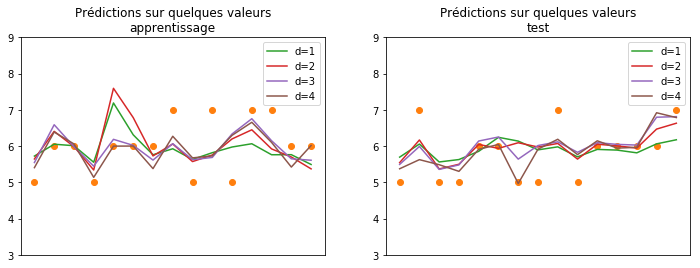

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

n = 15
ax[0].plot(y_train[:n].reset_index(), "o")
ax[1].plot(y_test[:n].reset_index(), "o")
ax[0].set_title("Prédictions sur quelques valeurs\napprentissage")
ax[1].set_title("Prédictions sur quelques valeurs\ntest")
for x in ax:
    x.set_ylim([3, 9])
    x.get_xaxis().set_visible(False)

for model in models:
    d = model.get_params()["polynomialfeatures__degree"]
    tr = model.predict(X_train_norm[:n])
    te = model.predict(X_test_norm[:n])
    ax[0].plot(tr, label="d=%d" % d)
    ax[1].plot(te, label="d=%d" % d)
ax[0].legend()
ax[1].legend();

Le modèle de degré 4 a l'air performant sur la base d'apprentissage mais s'égare complètement sur la base de test comme s'il était surpris des valeurs rencontrées sur la base de test. On dit que le modèle fait du [sur-apprentissage](https://fr.wikipedia.org/wiki/Surapprentissage) ou [overfitting](https://en.wikipedia.org/wiki/Overfitting) en anglais. Le polynôme de degré fonctionne mieux que la régression linéaire simple. On peut se demander quelles sont les variables croisées qui ont un impact sur la performance. On utilise le modèle [statsmodels](http://www.statsmodels.org/stable/index.html).

In [8]:
poly = PolynomialFeatures(degree=2)
poly_feat_train = poly.fit_transform(X_train_norm)
poly_feat_test = poly.fit_transform(X_test_norm)

In [9]:
from statsmodels.regression.linear_model import OLS

model = OLS(y_train, poly_feat_train)
results = model.fit()
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.306     
Dependent Variable: quality          AIC:                10768.5223
Date:               2024-01-23 00:08 BIC:                11268.3493
No. Observations:   4872             Log-Likelihood:     -5307.3   
Df Model:           76               F-statistic:        29.30     
Df Residuals:       4795             Prob (F-statistic): 0.00      
R-squared:          0.317            Scale:              0.52557   
-------------------------------------------------------------------
          Coef.     Std.Err.     t    P>|t|     [0.025     0.975]  
-------------------------------------------------------------------
const     874.2126  1866.6100  0.4683 0.6396  -2785.1996  4533.6248
x1         17.2438    25.1175  0.6865 0.4924    -31.9980    66.4856
x2       -735.9147   164.2593 -4.4802 0.0000  -1057.9383  -413.8911
x3       -375.2205   200.9788 -1.8670 0.0620   -769.2311    18.7900
x4          2.1457    13.7859  0.1556 0.8763    -24.8809    29.1723
x5      -1219.9140   760.0849 -1.6050 0.1086  -2710.0291   270.2011
x6         33.0684     8.6300  3.8318 0.0001     16.1496    49.9873
x7         45.6122    23.6785  1.9263 0.0541     -0.8085    92.0328
x8      -1621.7821   721.4602 -2.2479 0.0246  -3036.1752  -207.3890
x9       -123.6719   196.5043 -0.6294 0.5291   -508.9104   261.5667
x10      -213.6188   172.6441 -1.2373 0.2160   -552.0806   124.8429
x11       274.6811    25.3731 10.8257 0.0000    224.9381   324.4241
x12      -888.0924  1860.0506 -0.4775 0.6331  -4534.6449  2758.4602
x13       213.0448   149.3410  1.4266 0.1538    -79.7320   505.8216
x14      -169.2454   191.2389 -0.8850 0.3762   -544.1614   205.6706
x15        -2.3959    21.0911 -0.1136 0.9096    -43.7441    38.9523
x16       151.4367   661.2643  0.2290 0.8189  -1144.9447  1447.8180
x17       -13.3943     9.8122 -1.3651 0.1723    -32.6306     5.8421
x18       -12.3144    22.1599 -0.5557 0.5784    -55.7580    31.1291
x19      -228.1023  1055.2972 -0.2161 0.8289  -2296.9691  1840.7644
x20       263.5729   260.8085  1.0106 0.3123   -247.7314   774.8773
x21       210.1261   147.0152  1.4293 0.1530    -78.0912   498.3434
x22      -102.4573    26.1357 -3.9202 0.0001   -153.6952   -51.2193
x23     -1256.2263  1979.4050 -0.6346 0.5257  -5136.7684  2624.3158
x24      2503.6940  1629.0043  1.5369 0.1244   -689.9019  5697.2899
x25      -304.5840   139.4970 -2.1834 0.0291   -578.0621   -31.1060
x26      6503.3193  4276.6479  1.5207 0.1284  -1880.8729 14887.5116
x27       176.1465    65.4348  2.6919 0.0071     47.8643   304.4288
x28       541.9165   145.6814  3.7199 0.0002    256.3141   827.5190
x29     -5408.0462  5170.0682 -1.0460 0.2956 -15543.7521  4727.6598
x30      1591.6613  1576.5785  1.0096 0.3128  -1499.1559  4682.4786
x31     -3066.2318  1347.2069 -2.2760 0.0229  -5707.3755  -425.0882
x32       611.6934   183.2814  3.3375 0.0009    252.3778   971.0089
x33       861.9664  2070.4337  0.4163 0.6772  -3197.0336  4920.9664
x34      -307.3877   171.8498 -1.7887 0.0737   -644.2921    29.5168
x35     -8483.4913  6547.3948 -1.2957 0.1951 -21319.3893  4352.4067
x36       150.5489    83.1030  1.8116 0.0701    -12.3711   313.4689
x37       300.7497   178.4947  1.6849 0.0921    -49.1819   650.6813
x38     14067.7740  7800.2113  1.8035 0.0714  -1224.2191 29359.7672
x39     -5133.5558  2077.6861 -2.4708 0.0135  -9206.7738 -1060.3378
x40     -2372.2746  1576.8448 -1.5044 0.1325  -5463.6139   719.0647
x41       708.8006   236.3385  2.9991 0.0027    245.4687  1172.1325
x42      -910.1293  1867.0943 -0.4875 0.6260  -4570.4908  2750.2323
x43      1971.4865   757.4887  2.6027 0.0093    486.4611  3456.5118
x44        -7.6328     5.0273 -1.5183 0.1290    -17.4886     2.2230
x45         2.8665    12.6000  0.2275 0.8200    -21.8354    27.5684
x46      1429.2194   705.

Ce n'est pas très lisible. Il faut ajouter le nom de chaque variable et recommencer.

In [12]:
names = poly.get_feature_names_out(input_features=data.columns[:-2])
names = [n.replace(" ", " * ") for n in names]
pft = pandas.DataFrame(poly_feat_train, columns=names)
pft.head()

,1,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,...,density^2,density * pH,density * sulphates,density * alcohol,pH^2,pH * sulphates,pH * alcohol,sulphates^2,sulphates * alcohol,alcohol^2
0,1.0,0.061316,0.003511,0.003461,0.019779,0.000455,0.306582,0.939526,0.009773,0.030263,...,0.000096,0.000296,0.000044,0.001315,0.000916,0.000138,0.004070,0.000021,0.000612,0.018090
1,1.0,0.035236,0.001373,0.001922,0.065438,0.000206,0.205924,0.974706,0.004572,0.014552,...,0.000021,0.000067,0.000013,0.000192,0.000212,0.000042,0.000613,0.000008,0.000121,0.001772
2,1.0,0.042579,0.001319,0.001919,0.101349,0.000336,0.293852,0.947522,0.005996,0.020210,...,0.000036,0.000121,0.000014,0.000345,0.000408,0.000046,0.001163,0.000005,0.000131,0.003314
3,1.0,0.053638,0.000920,0.001456,0.037547,0.000421,0.206890,0.973147,0.007627,0.025210,...,0.000058,0.000192,0.000024,0.000549,0.000636,0.000079,0.001816,0.000010,0.000226,0.005188
4,1.0,0.071498,0.002413,0.002949,0.010725,0.000447,0.366428,0.920540,0.008848,0.026812,...,0.000078,0.000237,0.000036,0.000981,0.000719,0.000108,0.002971,0.000016,0.000446,0.012282


In [13]:
results.summary2(xname=pft.columns)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                    Results: Ordinary least squares
=======================================================================================================
Model:                          OLS                          Adj. R-squared:                 0.306     
Dependent Variable:             quality                      AIC:                            10768.5223
Date:                           2024-01-23 00:09             BIC:                            11268.3493
No. Observations:               4872                         Log-Likelihood:                 -5307.3   
Df Model:                       76                           F-statistic:                    29.30     
Df Residuals:                   4795                         Prob (F-statistic):             0.00      
R-squared:                      0.317                        Scale:                          0.52557   
-------------------------------------------------------------------------------------------------------
                                              Coef.     Std.Err.     t    P>|t|     [0.025     0.975]  
-------------------------------------------------------------------------------------------------------
1                                             874.2126  1866.6100  0.4683 0.6396  -2785.1996  4533.6248
fixed_acidity                                  17.2438    25.1175  0.6865 0.4924    -31.9980    66.4856
volatile_acidity                             -735.9147   164.2593 -4.4802 0.0000  -1057.9383  -413.8911
citric_acid                                  -375.2205   200.9788 -1.8670 0.0620   -769.2311    18.7900
residual_sugar                                  2.1457    13.7859  0.1556 0.8763    -24.8809    29.1723
chlorides                                   -1219.9140   760.0849 -1.6050 0.1086  -2710.0291   270.2011
free_sulfur_dioxide                            33.0684     8.6300  3.8318 0.0001     16.1496    49.9873
total_sulfur_dioxide                           45.6122    23.6785  1.9263 0.0541     -0.8085    92.0328
density                                     -1621.7821   721.4602 -2.2479 0.0246  -3036.1752  -207.3890
pH                                           -123.6719   196.5043 -0.6294 0.5291   -508.9104   261.5667
sulphates                                    -213.6188   172.6441 -1.2373 0.2160   -552.0806   124.8429
alcohol                                       274.6811    25.3731 10.8257 0.0000    224.9381   324.4241
fixed_acidity^2                              -888.0924  1860.0506 -0.4775 0.6331  -4534.6449  2758.4602
fixed_acidity * volatile_acidity              213.0448   149.3410  1.4266 0.1538    -79.7320   505.8216
fixed_acidity * citric_acid                  -169.2454   191.2389 -0.8850 0.3762   -544.1614   205.6706
fixed_acidity * residual_sugar                 -2.3959    21.0911 -0.1136 0.9096    -43.7441    38.9523
fixed_acidity * chlorides                     151.4367   661.2643  0.2290 0.8189  -1144.9447  1447.8180
fixed_acidity * free_sulfur_dioxide           -13.3943     9.8122 -1.3651 0.1723    -32.6306     5.8421
fixed_acidity * total_sulfur_dioxide          -12.3144    22.1599 -0.5557 0.5784    -55.7580    31.1291
fixed_acidity * density                      -228.1023  1055.2972 -0.2161 0.8289  -2296.9691  1840.7644
fixed_acidity * pH                            263.5729   260.8085  1.0106 0.3123   -247.7314   774.8773
fixed_acidity * sulphates                     210.1261   147.0152  1.4293 0.1530    -78.0912   498.3434
fixed_acidity * alcohol                      -102.4573    26.1357 -3.9202 0.0001   -153.6952   -51.2193
volatile_acidity^2                          -1256.2263  1979.4050 -0.6346 0.5257  -5136.7684  2624.3158
volatile_acidity * citric_acid               2503.6940  1629.0043  1.5369 0.1244   -689.9019  5697.2899
volatile_acidity * residual_sugar            -304.5840   139.4970 -2.1834 0.0291   -578.0621   -31.1060
volatile_acidity * chlorides       

On ne garde que celles dont la [p-value](https://sdpython.github.io/doc/mlstatpy/dev/c_metric/pvalues.html) est inférieur à 0.05.

In [14]:
pval = results.pvalues.copy()
pval[pval <= 0.05]

x2     7.630773e-06
x6     1.288486e-04
x8     2.462679e-02
x11    5.327338e-27
x22    8.970958e-05
x25    2.905133e-02
x27    7.128466e-03
x28    2.016020e-04
x31    2.289041e-02
x32    8.519337e-04
x39    1.351547e-02
x41    2.721775e-03
x43    9.278805e-03
x46    4.291916e-02
x56    9.249665e-03
x58    1.192719e-03
x62    2.657965e-10
x67    1.010018e-19
x71    2.225201e-02
x72    3.960632e-04
x74    2.109039e-03
x76    4.646809e-03
dtype: float64

In [15]:
pval.index = pft.columns
pval[pval <= 0.05]

volatile_acidity                              7.630773e-06
free_sulfur_dioxide                           1.288486e-04
density                                       2.462679e-02
alcohol                                       5.327338e-27
fixed_acidity * alcohol                       8.970958e-05
volatile_acidity * residual_sugar             2.905133e-02
volatile_acidity * free_sulfur_dioxide        7.128466e-03
volatile_acidity * total_sulfur_dioxide       2.016020e-04
volatile_acidity * sulphates                  2.289041e-02
volatile_acidity * alcohol                    8.519337e-04
citric_acid * pH                              1.351547e-02
citric_acid * alcohol                         2.721775e-03
residual_sugar * chlorides                    9.278805e-03
residual_sugar * density                      4.291916e-02
chlorides * alcohol                           9.249665e-03
free_sulfur_dioxide * total_sulfur_dioxide    1.192719e-03
free_sulfur_dioxide * alcohol                 2.657965e-

Le modèle fonctionne mieux mais il est plus compliqué de savoir si la contribution de l'alcool est corrélée positivement avec la qualité car l'alcool apparaît dans plus d'une variable.